In [1]:
import numpy as np
np.set_printoptions(threshold = np.nan, linewidth = 115)
import pickle

# Load with pickle instead of processing images again
training_img_1 = pickle.load(open('1vAll_img_res_Infiltration_1st_half.p', 'rb'))
training_img_2 = pickle.load(open('1vAll_img_res_Infiltration_2nd_half.p', 'rb'))

In [2]:
training_img_one = np.append(training_img_1, training_img_2, axis=0)

In [3]:
training_img_3 = pickle.load(open('1vAll_img_res_Infiltration_3rd_half.p', 'rb'))
training_img_4 = pickle.load(open('1vAll_img_res_Infiltration_4th_half.p', 'rb'))

In [4]:
training_img_two = np.append(training_img_3, training_img_4, axis=0)

In [11]:
training_img = np.append(training_img_one, training_img_two, axis=0)

training_img.shape

(36298, 256, 256, 1)

In [12]:
val_img = training_img[:2269]
val_img = np.append(val_img, training_img[34029:], axis=0)
training_img = training_img[2269:34029]
print(len(val_img))
print(len(training_img))
print(len(training_img) + len(val_img))

4538
31760
36298


In [13]:
labels_1 = pickle.load(open('1vAll_labels_res_Infiltration_1st_half.p', 'rb'))
labels_2 = pickle.load(open('1vAll_labels_res_Infiltration_2nd_half.p', 'rb'))
labels_3 = pickle.load(open('1vAll_labels_res_Infiltration_3rd_half.p', 'rb'))
labels_4 = pickle.load(open('1vAll_labels_res_Infiltration_4th_half.p', 'rb'))

In [14]:
training_labels = np.append(labels_1, np.append(labels_2, np.append(labels_3, labels_4, axis = 0), axis = 0), axis = 0)

In [15]:
val_labels = training_labels[:2269]
val_labels = np.append(val_labels, training_labels[34029:], axis=0)
training_labels = training_labels[2269:34029]
print(len(val_labels))
print(len(training_labels))
print(len(training_labels) + len(val_labels))

4538
31760
36298


In [16]:
test_img = pickle.load(open('1vAll_test_img.p', 'rb'))
test_labels = pickle.load(open('1vAll_test_labels.p', 'rb'))

print('Labels shape: ', training_labels.shape)
print('Length of test_labels: ', len(test_labels))
print('No. of Infiltration Diagnoses: ', sum(training_labels))

Labels shape:  (31760,)
Length of test_labels:  3490
No. of Infiltration Diagnoses:  15880


In [17]:
import keras
from keras import models, optimizers, layers, regularizers, metrics, losses
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU, ReLU, ThresholdedReLU
from keras.layers.core import Dense, Dropout, SpatialDropout2D, Activation
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.models import model_from_json, Sequential
from keras.callbacks import Callback

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)

import matplotlib.pyplot as plt

IMG_SIZE = 256

# Save Comparison model
def save_model(model_name, hist_str, model_str):

    pickle.dump(model_name.history, open('Training Histories/'+ hist_str + '.p', 'wb'))
    
    print("Saved " + hist_str + " to Training Histories folder")
    
    # serialize model to JSON
    model_name = model.to_json()
    with open("CNN Models/" + model_str + ".json", "w") as json_file:
        json_file.write(model_name)

    # serialize weights to HDF5
    model.save_weights("CNN Models/" + model_str + ".h5")
    print("Saved " + model_str + " and weights to CNN Models folder")
    
# Load model architecture and weights NOTE: must compile again
def load_model():
    model_str = str(input("Name of model to load: "))

    # load json and create model
    json_file = open('CNN Models/' + model_str + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("CNN Models/" + model_str + ".h5")
    print("Loaded " + model_str + " and weights from CNN Models folder")
    
    return loaded_model
    
# Load history object
def load_history():
    hist_str = str(input("Name of history to load: "))

    loaded_history = pickle.load(open('Training Histories/' + hist_str + '.p', 'rb'))
    
    print("Loaded " + hist_str + " from Training Histories folder")
    
    return loaded_history

Infiltration_class_weight = [{0: 1, 1: 12.938}]

### Custom Loss function
#from keras import backend as K

#def LSEP(true_label, pred_label):
#    return K.log(1 + K.sum(K.exp(true_label - pred_label)))

class True_Eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.total_accuracy = []
        self.i_accuracy = []
        self.e_accuracy = []
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(prediction)):
            if (y_true[i].round() == 0):
                if (prediction[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (prediction[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)

    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        y_pred = self.model.predict(x_val)
        i_real_acc, e_real_acc = self.ie_real_acc(y_pred)
        print ("T Acc: %f" % i_real_acc)
        print ("F Acc: %f" % e_real_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)
        

class MultiLabel_Acc(Callback):
    
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.accuracy = []
        
    def getAccuracy(self, prediction):
        y_true = self.validation_data[1]
        
        correct = []
        total = []
        accuracy = []
        
        for i in range(0, len(y_true[0])):
            correct.append([0, 0])
            total.append([0, 0])
        
        for sample in range(0, len(prediction)):
            for neuron in range(0, len(prediction[sample])):
                
                if (y_true[sample][neuron] == 0.0):
                    if (round(prediction[sample][neuron]) == y_true[sample][neuron]):
                        correct[neuron][0] += 1
                    total[neuron][0] += 1
                    
                if (y_true[sample][neuron] == 1.0):
                    if (round(prediction[sample][neuron]) == y_true[sample][neuron]):
                        correct[neuron][1] += 1
                    total[neuron][1] += 1
        
        for neuron in range(0, len(correct)):
            accuracy.append((correct[neuron][0]/total[neuron][0],
                                  correct[neuron][1]/total[neuron][1]))
        return accuracy
                    
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.validation_data[0])
        epoch_data = self.getAccuracy(y_pred)
        self.accuracy.append(epoch_data)
        
        for i in range(0, len(epoch_data)):
            print("         Neuron: #"+ str(i + 1))
            print("Zeroes Accuracy:", epoch_data[i][0])
            print("  Ones Accuracy:", epoch_data[i][1])
            
            
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    _fontsize = 'xx-large'
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without Normalization")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=_fontsize)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, fontsize=_fontsize) 
    plt.yticks(tick_marks, classes, fontsize=_fontsize)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + 0.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = 'center',
                color='white' if cm[i, j] > thresh else 'black', 
                fontsize=_fontsize)
    
    plt.tight_layout()
    plt.ylabel('True Labels', fontsize=_fontsize)
    plt.xlabel('Predicted Labels', fontsize=_fontsize)

# Metric Analysis
def _1vAll_accuracy(y_test, pred):
    
    pred = np.squeeze(pred, axis = -1)
    pred = np.round_(pred)
    pred = pred.astype(dtype = 'uint8')
    
    ft = pred == y_test
    
    accuracy = sum(ft)/len(ft)
        
    print('\t Complete Label Accuracy: %.2f' % round((accuracy * 100), 2), '%')
    
    print('Sum of Fully Correct Predictions: ', sum(ft))
    print('\t\t    Total Labels: ', len(ft))
    
    return accuracy

Using TensorFlow backend.


### One Vs. All

In [ ]:
'''
Deep Residual Neural Network

v2: Changed cardinality (4 -> 16), I/O Channels in Residual Blocks, 
    Batch Normalization in 'add_common_layers()', 
    and included SpatialDropout2D to 'add_common_layers()'
'''     

img_height = 256
img_width = 256
img_channels = 1

#
# network params
#

cardinality = 16


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.SpatialDropout2D(0.125)(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.ReLU()(y)

        return y

    # conv block 1
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = add_common_layers(x)
    x = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(x)
    
    # residual block
    for i in range(3):
        project_shortcut = (i == 0)
        x = residual_block(x, 16, 32, _project_shortcut=project_shortcut)

    # conv block 2
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = add_common_layers(x)    
    x = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(x)
    
    # conv block 3
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = add_common_layers(x)    
    x = layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')(x)
    
    
    
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (1, 1)
        x = residual_block(x, 16, 32, _strides=strides)

    # conv4
    for i in range(6):
        strides = (1, 1)
        x = residual_block(x, 32, 64, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 64, 128, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16)(x)
    x = layers.Dense(1)(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())

Name of model to load: RNN_Test
Loaded RNN_Test and weights from CNN Models folder
Train on 31760 samples, validate on 4538 samples
Epoch 101/150
 - 167s - loss: 0.7347 - acc: 0.5486 - val_loss: 0.6818 - val_acc: 0.5765
         Neuron: #0
Zeroes Accuracy: 0.5702952842661966
  Ones Accuracy: 0.5826355222565006
Epoch 102/150
 - 163s - loss: 0.6766 - acc: 0.5897 - val_loss: 0.6764 - val_acc: 0.5646
         Neuron: #0
Zeroes Accuracy: 0.7584839136183341
  Ones Accuracy: 0.37064786249449094
Epoch 103/150
 - 161s - loss: 0.6644 - acc: 0.6039 - val_loss: 0.6799 - val_acc: 0.5919
         Neuron: #0
Zeroes Accuracy: 0.6033494931687968
  Ones Accuracy: 0.5804319083296606
Epoch 104/150
 - 162s - loss: 0.6604 - acc: 0.6105 - val_loss: 0.6509 - val_acc: 0.6058
         Neuron: #0
Zeroes Accuracy: 0.6822388717496695
  Ones Accuracy: 0.5293080652269723
Epoch 105/150
 - 163s - loss: 0.6544 - acc: 0.6177 - val_loss: 0.6532 - val_acc: 0.5974
         Neuron: #0
Zeroes Accuracy: 0.753635962979286
  On

 - 166s - loss: 0.5205 - acc: 0.7311 - val_loss: 1.6457 - val_acc: 0.5657
         Neuron: #0
Zeroes Accuracy: 0.7183781401498458
  Ones Accuracy: 0.4129572498898193
Epoch 147/150
 - 166s - loss: 0.5134 - acc: 0.7341 - val_loss: 1.6689 - val_acc: 0.5491
         Neuron: #0
Zeroes Accuracy: 0.6826795945350375
  Ones Accuracy: 0.41560158660202734
Epoch 148/150
 - 164s - loss: 0.5047 - acc: 0.7349 - val_loss: 1.2418 - val_acc: 0.5657
         Neuron: #0
Zeroes Accuracy: 0.5522256500661085
  Ones Accuracy: 0.5791097399735566
Epoch 149/150
 - 166s - loss: 0.5076 - acc: 0.7377 - val_loss: 1.2555 - val_acc: 0.5725
         Neuron: #0
Zeroes Accuracy: 0.5249008373732922
  Ones Accuracy: 0.620096959012781
Epoch 150/150
 - 166s - loss: 0.5041 - acc: 0.7386 - val_loss: 1.3691 - val_acc: 0.5692
         Neuron: #0
Zeroes Accuracy: 0.45085940943146763
  Ones Accuracy: 0.6875275451740855
	 Complete Label Accuracy: 56.50 %
Sum of Fully Correct Predictions:  1972
		    Total Labels:  3490
Saved ResNet

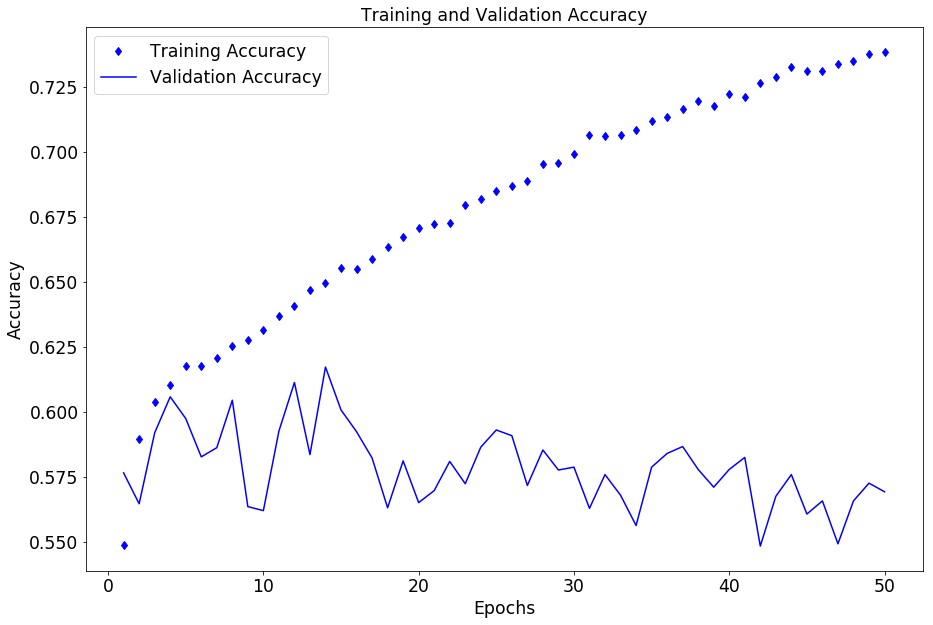

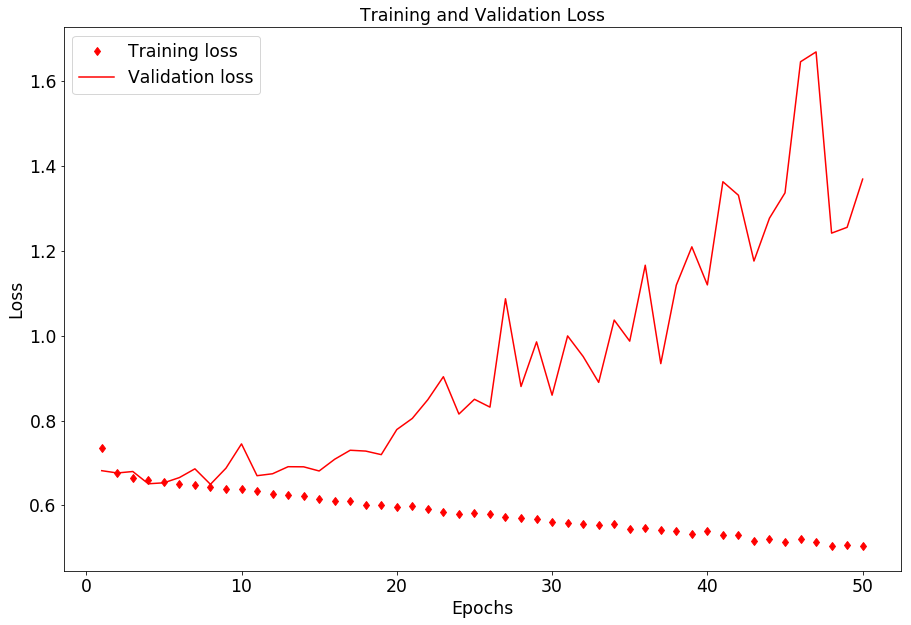

Normalized Confusion Matrix


c:\users\rocke\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in true_divide
c:\users\rocke\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


<Figure size 432x288 with 0 Axes>

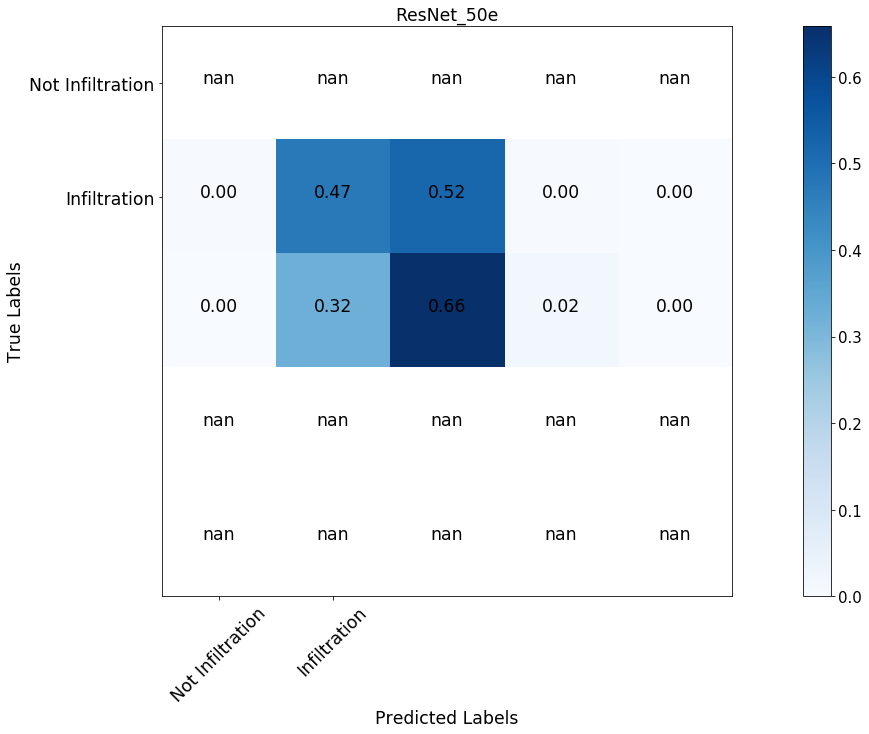

In [19]:
# Last model: RNN_Test
#model = load_model()
#model.summary()

model.compile(optimizer = optimizers.RMSprop(lr = 1e-4), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

custom_metrics = MultiLabel_Acc((val_img, val_labels))

model_obj = model.fit(training_img, training_labels, 
                      epochs = 50, initial_epoch = 25, 
                      validation_data = (val_img, val_labels), 
                      batch_size = 64, verbose = 1, 
                      callbacks = [custom_metrics])

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = 'ResNet_50e_history'
model_str   = 'ResNet_50e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(15, 10))
plt.plot(epochs, acc, 'bd', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Accuracy', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()
plt.figure(figsize=(15, 10))
plt.plot(epochs, loss, 'rd', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize='xx-large')
plt.xticks(fontsize='xx-large')
plt.xlabel('Epochs', fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.ylabel('Loss', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (20, 10))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

In [22]:
rnn_test_history = load_history()
print(len(rnn_test_history['acc']))

Name of history to load: RNN_Test_history
Loaded RNN_Test_history from Training Histories folder
25
